In [1]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
from numpy import asarray
from numpy import save
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [2]:
train_df = pd.read_csv("trainlist.txt",header = None)

dataframe1 = pd.DataFrame(train_df)
dataframe1.columns = ["videos"]

In [3]:
dataframe1["Tags"] = pd.read_csv("traintag.txt")
dataframe1

,videos,Tags
0,Basketball/v_Basketball_g01_c01.avi,Basketball
1,Basketball/v_Basketball_g01_c02.avi,Basketball
2,Basketball/v_Basketball_g01_c03.avi,Basketball
3,Basketball/v_Basketball_g01_c04.avi,Basketball
4,Basketball/v_Basketball_g01_c05.avi,Basketball
5,Basketball/v_Basketball_g01_c06.avi,Basketball
6,Basketball/v_Basketball_g01_c07.avi,Basketball
7,Biking/v_Biking_g01_c01.avi,Biking
8,Biking/v_Biking_g01_c02.avi,Biking
9,Biking/v_Biking_g01_c03.avi,Biking


In [4]:
test_df = pd.read_csv("testlist.txt",header = None)

dataframe2 = pd.DataFrame(test_df)
dataframe2.columns = ["videos"]
dataframe2

,videos
0,Basketball/v_Basketball_g02_c01.avi
1,Basketball/v_Basketball_g02_c02.avi
2,Basketball/v_Basketball_g02_c03.avi
3,Biking/v_Biking_g02_c05.avi
4,Biking/v_Biking_g02_c06.avi
5,Biking/v_Biking_g02_c07.avi
6,CliffDiving/v_CliffDiving_g02_c02.avi
7,CliffDiving/v_CliffDiving_g02_c03.avi
8,CliffDiving/v_CliffDiving_g02_c04.avi
9,CricketBowling/v_CricketBowling_g02_c01.avi


In [5]:
dataframe2["Tags"] = pd.read_csv("testtag.txt")
dataframe2

,videos,Tags
0,Basketball/v_Basketball_g02_c01.avi,Basketball
1,Basketball/v_Basketball_g02_c02.avi,Basketball
2,Basketball/v_Basketball_g02_c03.avi,Basketball
3,Biking/v_Biking_g02_c05.avi,Biking
4,Biking/v_Biking_g02_c06.avi,Biking
5,Biking/v_Biking_g02_c07.avi,Biking
6,CliffDiving/v_CliffDiving_g02_c02.avi,CliffDiving
7,CliffDiving/v_CliffDiving_g02_c03.avi,CliffDiving
8,CliffDiving/v_CliffDiving_g02_c04.avi,CliffDiving
9,CricketBowling/v_CricketBowling_g02_c01.avi,CricketBowling


In [6]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

In [7]:
print(f"Total videos for training: {len(dataframe1)}")
print(f"Total videos for testing: {len(dataframe2)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped



def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(dataframe1["Tags"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["videos"].values.tolist()
    #print(video_paths)
    labels = df["Tags"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        #print(frames)

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()
        #train_data = pd.DataFrame(data = frame_features)
        #train_label = pd.DataFrame(data = labels)
        save('test_data.npy', frame_features)
        save('test_label.npy', labels)
    return frame_features, labels 

Total videos for training: 28
Total videos for testing: 12
['Basketball', 'Biking', 'CliffDiving', 'CricketBowling']


In [8]:
prepare_all_videos(dataframe1,r"C:\\Users\\ADM\\OneDrive\\Desktop\\data science\\projects\\dsa intern assessment\\data")

1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 58ms/step


(array([[[2.34704465e-04, 3.54015199e-03, 3.87241016e-03, ...,
          2.23480368e+00, 2.87601709e+00, 3.09823847e+00],
         [2.35350497e-04, 3.56471469e-03, 3.90840834e-03, ...,
          2.20415235e+00, 2.91213655e+00, 3.18411398e+00],
         [2.74218619e-04, 3.68424924e-03, 4.41638380e-03, ...,
          1.94785810e+00, 3.04605126e+00, 2.66807604e+00],
         ...,
         [1.77485272e-04, 4.51198220e-03, 4.47086571e-03, ...,
          2.96298742e+00, 4.31930256e+00, 1.99768710e+00],
         [1.74496410e-04, 4.53405175e-03, 4.30983445e-03, ...,
          2.82931471e+00, 4.25601959e+00, 2.05601954e+00],
         [1.57553673e-04, 5.25709707e-03, 3.65473866e-03, ...,
          4.21803856e+00, 3.85606337e+00, 1.82142019e+00]],
 
        [[2.04586540e-04, 5.69126848e-03, 4.52305702e-03, ...,
          9.25710797e-01, 2.31208158e+00, 3.27806878e+00],
         [1.91706524e-04, 5.27833682e-03, 4.33208002e-03, ...,
          1.00282621e+00, 2.12581277e+00, 2.46078491e+00],
       

In [9]:
prepare_all_videos(dataframe2,r"C:\\Users\\ADM\\OneDrive\\Desktop\\data science\\projects\\dsa intern assessment\\data")

1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 60ms/step


(array([[[3.1533820e-04, 2.8452203e-03, 1.6528392e-03, ...,
          1.8458338e+00, 1.6143081e+00, 3.9679627e+00],
         [2.5611013e-04, 2.9369865e-03, 1.7283150e-03, ...,
          1.5657966e+00, 1.2413037e+00, 4.8299761e+00],
         [1.8815410e-04, 2.3391265e-03, 2.1408263e-03, ...,
          1.3186052e+00, 2.0277236e+00, 4.0000362e+00],
         ...,
         [3.1931631e-04, 4.6757758e-03, 1.9619949e-03, ...,
          9.1605014e-01, 2.8264828e+00, 4.4698687e+00],
         [3.2702379e-04, 4.7246828e-03, 2.4188752e-03, ...,
          1.1040434e+00, 3.1660388e+00, 4.1370602e+00],
         [4.4249589e-04, 3.2499128e-03, 2.5707453e-03, ...,
          1.2237884e+00, 2.7099905e+00, 4.0695038e+00]],
 
        [[3.9830705e-04, 3.6889976e-03, 1.5959090e-03, ...,
          4.4702330e-01, 2.3359234e+00, 4.2985268e+00],
         [3.4821223e-04, 3.9669191e-03, 1.5488866e-03, ...,
          8.4233743e-01, 2.7370629e+00, 4.5570111e+00],
         [3.3234959e-04, 5.4298346e-03, 1.8991102e-03, 

In [10]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_label.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_label.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (28, 20, 1024)


In [11]:
train_data

array([[[2.34704465e-04, 3.54015199e-03, 3.87241016e-03, ...,
         2.23480368e+00, 2.87601709e+00, 3.09823847e+00],
        [2.35350497e-04, 3.56471469e-03, 3.90840834e-03, ...,
         2.20415235e+00, 2.91213655e+00, 3.18411398e+00],
        [2.74218619e-04, 3.68424924e-03, 4.41638380e-03, ...,
         1.94785810e+00, 3.04605126e+00, 2.66807604e+00],
        ...,
        [1.77485272e-04, 4.51198220e-03, 4.47086571e-03, ...,
         2.96298742e+00, 4.31930256e+00, 1.99768710e+00],
        [1.74496410e-04, 4.53405175e-03, 4.30983445e-03, ...,
         2.82931471e+00, 4.25601959e+00, 2.05601954e+00],
        [1.57553673e-04, 5.25709707e-03, 3.65473866e-03, ...,
         4.21803856e+00, 3.85606337e+00, 1.82142019e+00]],

       [[2.04586540e-04, 5.69126848e-03, 4.52305702e-03, ...,
         9.25710797e-01, 2.31208158e+00, 3.27806878e+00],
        [1.91706524e-04, 5.27833682e-03, 4.33208002e-03, ...,
         1.00282621e+00, 2.12581277e+00, 2.46078491e+00],
        [1.55676869e-04, 

In [12]:
test_data

array([[[3.1533820e-04, 2.8452203e-03, 1.6528392e-03, ...,
         1.8458338e+00, 1.6143081e+00, 3.9679627e+00],
        [2.5611013e-04, 2.9369865e-03, 1.7283150e-03, ...,
         1.5657966e+00, 1.2413037e+00, 4.8299761e+00],
        [1.8815410e-04, 2.3391265e-03, 2.1408263e-03, ...,
         1.3186052e+00, 2.0277236e+00, 4.0000362e+00],
        ...,
        [3.1931631e-04, 4.6757758e-03, 1.9619949e-03, ...,
         9.1605014e-01, 2.8264828e+00, 4.4698687e+00],
        [3.2702379e-04, 4.7246828e-03, 2.4188752e-03, ...,
         1.1040434e+00, 3.1660388e+00, 4.1370602e+00],
        [4.4249589e-04, 3.2499128e-03, 2.5707453e-03, ...,
         1.2237884e+00, 2.7099905e+00, 4.0695038e+00]],

       [[3.9830705e-04, 3.6889976e-03, 1.5959090e-03, ...,
         4.4702330e-01, 2.3359234e+00, 4.2985268e+00],
        [3.4821223e-04, 3.9669191e-03, 1.5488866e-03, ...,
         8.4233743e-01, 2.7370629e+00, 4.5570111e+00],
        [3.3234959e-04, 5.4298346e-03, 1.8991102e-03, ...,
         7.551

In [13]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(input_dim = sequence_length, output_dim = output_dim)
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [15]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(sequence_length, embed_dim, name="frame_position_embedding")(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [16]:
def run_experiment():
    filepath =r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

In [20]:
trained_model = run_experiment()

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0551 - accuracy: 0.1739
Epoch 1: val_loss improved from inf to 11.14478, saving model to C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data
1/1 [==============================] - 1s 1s/step - loss: 4.0551 - accuracy: 0.1739 - val_loss: 11.1448 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2470 - accuracy: 0.4783
Epoch 2: val_loss improved from 11.14478 to 8.21811, saving model to C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data
1/1 [==============================] - 0s 333ms/step - loss: 3.2470 - accuracy: 0.4783 - val_loss: 8.2181 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8560 - accuracy: 0.6087
Epoch 3: val_loss improved from 8.21811 to 1.05707, saving model to C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data
1/1 [===================

In [21]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0
    #print(frame_features)
    return frame_features

In [22]:
def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    print(frames)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    #print(frames)
    return frames

[[[[122. 115.  99.]
   [122. 115.  99.]
   [122. 115.  99.]
   ...
   [124. 112. 100.]
   [124. 112. 100.]
   [124. 112. 100.]]

  [[122. 115.  99.]
   [122. 115.  99.]
   [122. 115.  99.]
   ...
   [124. 112. 100.]
   [124. 112. 100.]
   [124. 112. 100.]]

  [[120. 116.  99.]
   [120. 116.  99.]
   [120. 116.  99.]
   ...
   [124. 112. 100.]
   [124. 112. 100.]
   [124. 112. 100.]]

  ...

  [[121. 107.  80.]
   [121. 107.  80.]
   [121. 107.  80.]
   ...
   [128. 114.  89.]
   [136. 122.  97.]
   [143. 129. 104.]]

  [[122. 106.  75.]
   [122. 106.  75.]
   [123. 107.  76.]
   ...
   [130. 115.  79.]
   [129. 114.  78.]
   [128. 113.  77.]]

  [[121. 105.  74.]
   [122. 106.  75.]
   [123. 107.  76.]
   ...
   [130. 115.  79.]
   [135. 120.  84.]
   [138. 123.  87.]]]


 [[[122. 115.  99.]
   [122. 115.  99.]
   [122. 115.  99.]
   ...
   [124. 112. 100.]
   [124. 113.  98.]
   [124. 113.  98.]]

  [[122. 115.  99.]
   [122. 115.  99.]
   [122. 115.  99.]
   ...
   [124. 112. 100.]
 


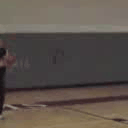

In [23]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\Basketball/v_Basketball_g02_c01.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[118. 108.  96.]
   [118. 108.  96.]
   [118. 108.  96.]
   ...
   [121. 107.  93.]
   [121. 107.  93.]
   [121. 107.  93.]]

  [[118. 108.  96.]
   [118. 108.  96.]
   [118. 108.  96.]
   ...
   [121. 107.  93.]
   [121. 107.  93.]
   [121. 107.  93.]]

  [[118. 108.  96.]
   [118. 108.  96.]
   [118. 108.  96.]
   ...
   [121. 106.  95.]
   [121. 106.  95.]
   [121. 106.  95.]]

  ...

  [[125. 105.  85.]
   [125. 105.  85.]
   [125. 105.  85.]
   ...
   [130. 112.  82.]
   [130. 112.  82.]
   [130. 112.  82.]]

  [[125. 106.  83.]
   [125. 106.  83.]
   [125. 106.  83.]
   ...
   [131. 111.  81.]
   [131. 111.  81.]
   [131. 111.  81.]]

  [[125. 106.  83.]
   [125. 106.  83.]
   [125. 106.  83.]
   ...
   [131. 111.  81.]
   [133. 113.  83.]
   [135. 115.  85.]]]


 [[[118. 108.  96.]
   [118. 108.  96.]
   [118. 108.  96.]
   ...
   [119. 105.  91.]
   [119. 105.  91.]
   [119. 105.  91.]]

  [[118. 108.  96.]
   [118. 108.  96.]
   [118. 108.  96.]
   ...
   [121. 107.  93.]
 


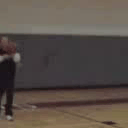

In [24]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
   
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\Basketball\v_Basketball_g02_c02.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[123. 113. 101.]
   [123. 113. 101.]
   [123. 113. 101.]
   ...
   [121. 111. 101.]
   [119. 109.  99.]
   [118. 108.  98.]]

  [[123. 113. 101.]
   [123. 113. 101.]
   [123. 113. 101.]
   ...
   [124. 114. 104.]
   [122. 112. 102.]
   [119. 109.  99.]]

  [[123. 113. 101.]
   [123. 113. 101.]
   [123. 113. 101.]
   ...
   [125. 117. 106.]
   [123. 115. 104.]
   [121. 113. 102.]]

  ...

  [[143. 120.  89.]
   [143. 120.  89.]
   [143. 120.  89.]
   ...
   [150. 127.  98.]
   [149. 126.  97.]
   [148. 125.  96.]]

  [[144. 121.  90.]
   [144. 121.  90.]
   [144. 121.  90.]
   ...
   [148. 125.  94.]
   [145. 122.  91.]
   [144. 121.  90.]]

  [[144. 121.  90.]
   [144. 121.  90.]
   [144. 121.  90.]
   ...
   [145. 122.  91.]
   [143. 120.  89.]
   [142. 119.  88.]]]


 [[[124. 114. 102.]
   [124. 114. 102.]
   [124. 114. 102.]
   ...
   [124. 114. 104.]
   [122. 112. 102.]
   [119. 109.  99.]]

  [[123. 113. 101.]
   [123. 113. 101.]
   [123. 113. 101.]
   ...
   [126. 116. 106.]
 


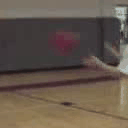

In [25]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
   


test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\Basketball\v_Basketball_g02_c03.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[ 88.  76.  81.]
   [ 88.  76.  81.]
   [ 88.  76.  81.]
   ...
   [139.  48.  79.]
   [145.  49.  82.]
   [149.  53.  86.]]

  [[ 94.  82.  87.]
   [ 94.  82.  87.]
   [ 94.  82.  87.]
   ...
   [129.  38.  69.]
   [137.  41.  74.]
   [148.  52.  85.]]

  [[103.  91.  96.]
   [103.  91.  96.]
   [103.  91.  96.]
   ...
   [103.  33.  57.]
   [113.  38.  64.]
   [129.  54.  80.]]

  ...

  [[187. 180. 183.]
   [187. 180. 183.]
   [187. 180. 183.]
   ...
   [191. 184. 187.]
   [191. 184. 187.]
   [191. 184. 187.]]

  [[187. 180. 183.]
   [187. 180. 183.]
   [187. 180. 183.]
   ...
   [191. 184. 187.]
   [191. 184. 187.]
   [191. 184. 187.]]

  [[185. 178. 181.]
   [185. 178. 181.]
   [185. 178. 181.]
   ...
   [191. 184. 187.]
   [191. 184. 187.]
   [191. 184. 187.]]]


 [[[ 88.  76.  81.]
   [ 88.  76.  81.]
   [ 88.  76.  81.]
   ...
   [103. 122. 111.]
   [ 95. 116. 114.]
   [ 86. 107. 105.]]

  [[ 94.  82.  87.]
   [ 94.  82.  87.]
   [ 94.  82.  87.]
   ...
   [ 96. 115. 104.]
 


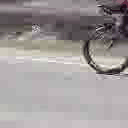

In [28]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
   


test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\Biking/v_Biking_g02_c05.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[106. 103. 107.]
   [106. 103. 107.]
   [108. 105. 109.]
   ...
   [ 21.  19.  17.]
   [ 28.  26.  24.]
   [ 33.  31.  29.]]

  [[120. 117. 121.]
   [117. 114. 118.]
   [112. 109. 113.]
   ...
   [ 25.  23.  21.]
   [ 37.  35.  33.]
   [ 44.  42.  40.]]

  [[119. 116. 120.]
   [116. 113. 117.]
   [109. 106. 110.]
   ...
   [ 21.  19.  17.]
   [ 40.  38.  36.]
   [ 52.  50.  48.]]

  ...

  [[254. 248. 241.]
   [254. 248. 241.]
   [254. 248. 241.]
   ...
   [165. 159. 152.]
   [154. 148. 141.]
   [148. 142. 135.]]

  [[254. 248. 241.]
   [254. 248. 241.]
   [254. 248. 241.]
   ...
   [215. 209. 202.]
   [208. 202. 195.]
   [206. 200. 193.]]

  [[254. 248. 241.]
   [254. 248. 241.]
   [254. 248. 241.]
   ...
   [250. 244. 237.]
   [252. 246. 239.]
   [252. 246. 239.]]]


 [[[102.  99. 103.]
   [102.  99. 103.]
   [103. 100. 104.]
   ...
   [ 21.  19.  17.]
   [ 28.  26.  24.]
   [ 33.  31.  29.]]

  [[122. 119. 123.]
   [118. 115. 119.]
   [113. 110. 114.]
   ...
   [ 25.  23.  21.]
 


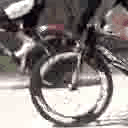

In [29]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\Biking\v_Biking_g02_c06.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[242. 252. 255.]
   [242. 252. 255.]
   [242. 252. 255.]
   ...
   [145. 148. 159.]
   [145. 148. 159.]
   [145. 148. 159.]]

  [[242. 252. 255.]
   [242. 252. 255.]
   [242. 252. 255.]
   ...
   [145. 148. 159.]
   [145. 148. 159.]
   [145. 148. 159.]]

  [[242. 252. 255.]
   [242. 252. 255.]
   [242. 252. 255.]
   ...
   [145. 148. 159.]
   [145. 148. 159.]
   [145. 148. 159.]]

  ...

  [[242. 235. 233.]
   [254. 247. 245.]
   [254. 247. 245.]
   ...
   [241. 234. 232.]
   [249. 242. 240.]
   [253. 246. 244.]]

  [[242. 235. 233.]
   [254. 247. 245.]
   [254. 247. 245.]
   ...
   [229. 222. 220.]
   [239. 232. 230.]
   [245. 238. 236.]]

  [[242. 235. 233.]
   [254. 247. 245.]
   [254. 247. 245.]
   ...
   [221. 214. 212.]
   [232. 225. 223.]
   [238. 231. 229.]]]


 [[[242. 252. 255.]
   [242. 252. 255.]
   [242. 252. 255.]
   ...
   [145. 148. 159.]
   [145. 148. 159.]
   [145. 148. 159.]]

  [[242. 252. 255.]
   [242. 252. 255.]
   [242. 252. 255.]
   ...
   [145. 148. 159.]
 


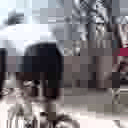

In [31]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\Biking\v_Biking_g02_c07.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[239. 255. 253.]
   [224. 240. 238.]
   [219. 235. 233.]
   ...
   [236. 250. 243.]
   [236. 250. 243.]
   [236. 250. 243.]]

  [[241. 255. 255.]
   [231. 247. 245.]
   [227. 243. 241.]
   ...
   [236. 250. 243.]
   [236. 250. 243.]
   [236. 250. 243.]]

  [[239. 255. 253.]
   [236. 252. 250.]
   [237. 253. 251.]
   ...
   [238. 250. 246.]
   [238. 250. 246.]
   [238. 250. 246.]]

  ...

  [[235. 248. 249.]
   [233. 246. 247.]
   [241. 252. 253.]
   ...
   [239. 249. 246.]
   [239. 249. 246.]
   [239. 249. 246.]]

  [[236. 249. 250.]
   [236. 249. 250.]
   [237. 248. 249.]
   ...
   [239. 249. 243.]
   [239. 249. 243.]
   [239. 249. 243.]]

  [[238. 251. 252.]
   [239. 252. 253.]
   [233. 244. 245.]
   ...
   [239. 249. 243.]
   [239. 249. 243.]
   [239. 249. 243.]]]


 [[[231. 248. 243.]
   [232. 249. 244.]
   [230. 246. 244.]
   ...
   [236. 250. 243.]
   [236. 250. 243.]
   [236. 250. 243.]]

  [[232. 249. 244.]
   [237. 254. 249.]
   [234. 250. 248.]
   ...
   [236. 250. 243.]
 


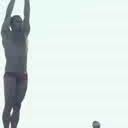

In [32]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\CliffDiving/v_CliffDiving_g02_c02.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[214. 248. 234.]
   [214. 248. 234.]
   [214. 248. 234.]
   ...
   [214. 247. 241.]
   [214. 247. 241.]
   [214. 247. 241.]]

  [[214. 248. 234.]
   [214. 248. 234.]
   [214. 248. 234.]
   ...
   [214. 247. 241.]
   [214. 247. 241.]
   [214. 247. 241.]]

  [[214. 248. 237.]
   [214. 248. 237.]
   [214. 248. 237.]
   ...
   [214. 247. 241.]
   [214. 247. 241.]
   [214. 247. 241.]]

  ...

  [[221. 245. 237.]
   [221. 245. 237.]
   [221. 245. 237.]
   ...
   [221. 245. 237.]
   [221. 245. 237.]
   [221. 245. 237.]]

  [[219. 245. 234.]
   [219. 245. 234.]
   [219. 245. 234.]
   ...
   [219. 245. 234.]
   [219. 245. 234.]
   [219. 245. 234.]]

  [[219. 245. 234.]
   [219. 245. 234.]
   [219. 245. 234.]
   ...
   [219. 245. 234.]
   [219. 245. 234.]
   [219. 245. 234.]]]


 [[[214. 248. 234.]
   [214. 248. 234.]
   [214. 248. 234.]
   ...
   [214. 247. 241.]
   [214. 247. 241.]
   [214. 247. 241.]]

  [[214. 248. 234.]
   [214. 248. 234.]
   [214. 248. 234.]
   ...
   [214. 247. 241.]
 


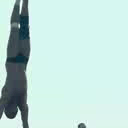

In [33]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\CliffDiving/v_CliffDiving_g02_c03.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[245. 252. 245.]
   [232. 239. 232.]
   [250. 255. 250.]
   ...
   [244. 246. 243.]
   [244. 246. 243.]
   [244. 246. 243.]]

  [[243. 250. 243.]
   [237. 244. 237.]
   [240. 247. 240.]
   ...
   [244. 246. 243.]
   [244. 246. 243.]
   [244. 246. 243.]]

  [[240. 247. 240.]
   [241. 248. 241.]
   [232. 239. 232.]
   ...
   [246. 246. 246.]
   [246. 246. 246.]
   [246. 246. 246.]]

  ...

  [[126. 126. 126.]
   [ 93.  93.  93.]
   [ 90.  90.  90.]
   ...
   [246. 246. 246.]
   [246. 246. 246.]
   [246. 246. 246.]]

  [[141. 143. 140.]
   [ 88.  90.  87.]
   [ 91.  93.  90.]
   ...
   [244. 246. 243.]
   [244. 246. 243.]
   [244. 246. 243.]]

  [[151. 153. 150.]
   [ 86.  88.  85.]
   [ 93.  95.  92.]
   ...
   [244. 246. 243.]
   [244. 246. 243.]
   [244. 246. 243.]]]


 [[[239. 244. 243.]
   [239. 244. 243.]
   [239. 244. 243.]
   ...
   [244. 246. 243.]
   [244. 246. 243.]
   [244. 246. 243.]]

  [[242. 247. 246.]
   [242. 247. 246.]
   [244. 249. 248.]
   ...
   [244. 246. 243.]
 


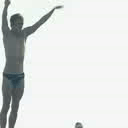

In [34]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\CliffDiving/v_CliffDiving_g02_c04.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[211. 211. 179.]
   [211. 211. 179.]
   [211. 211. 179.]
   ...
   [164. 164. 132.]
   [170. 170. 138.]
   [182. 182. 150.]]

  [[203. 203. 171.]
   [203. 203. 171.]
   [203. 203. 171.]
   ...
   [164. 164. 132.]
   [170. 170. 138.]
   [179. 179. 147.]]

  [[195. 195. 163.]
   [195. 195. 163.]
   [195. 195. 163.]
   ...
   [166. 166. 134.]
   [170. 170. 138.]
   [176. 176. 144.]]

  ...

  [[120. 142. 105.]
   [148. 170. 133.]
   [124. 146. 109.]
   ...
   [ 47.  73.  37.]
   [ 54.  80.  44.]
   [ 66.  92.  56.]]

  [[125. 147. 110.]
   [105. 127.  90.]
   [ 92. 114.  77.]
   ...
   [ 48.  78.  41.]
   [ 51.  81.  44.]
   [ 60.  90.  53.]]

  [[ 89. 111.  74.]
   [ 90. 112.  75.]
   [ 93. 115.  78.]
   ...
   [ 49.  79.  42.]
   [ 51.  81.  44.]
   [ 57.  87.  50.]]]


 [[[197. 197. 167.]
   [211. 211. 181.]
   [211. 211. 179.]
   ...
   [164. 164. 132.]
   [170. 170. 138.]
   [182. 182. 150.]]

  [[192. 192. 162.]
   [203. 203. 173.]
   [203. 203. 171.]
   ...
   [164. 164. 132.]
 


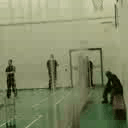

In [35]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\CricketBowling/v_CricketBowling_g02_c01.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[210. 209. 184.]
   [211. 210. 185.]
   [202. 201. 176.]
   ...
   [159. 162. 129.]
   [159. 162. 129.]
   [159. 162. 129.]]

  [[209. 208. 183.]
   [210. 209. 184.]
   [202. 201. 176.]
   ...
   [159. 162. 129.]
   [159. 162. 129.]
   [159. 162. 129.]]

  [[207. 205. 183.]
   [209. 207. 185.]
   [199. 197. 175.]
   ...
   [159. 162. 129.]
   [159. 162. 129.]
   [159. 162. 129.]]

  ...

  [[104. 119.  84.]
   [104. 119.  84.]
   [104. 119.  84.]
   ...
   [133. 136. 101.]
   [133. 136. 101.]
   [133. 136. 101.]]

  [[105. 120.  85.]
   [105. 120.  85.]
   [105. 120.  85.]
   ...
   [133. 137.  99.]
   [133. 137.  99.]
   [133. 137.  99.]]

  [[107. 122.  87.]
   [107. 122.  87.]
   [107. 122.  87.]
   ...
   [133. 137.  99.]
   [133. 137.  99.]
   [133. 137.  99.]]]


 [[[210. 209. 184.]
   [211. 210. 185.]
   [202. 201. 176.]
   ...
   [159. 162. 129.]
   [159. 162. 129.]
   [159. 162. 129.]]

  [[209. 208. 183.]
   [210. 209. 184.]
   [202. 201. 176.]
   ...
   [159. 162. 129.]
 


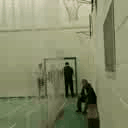

In [36]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\CricketBowling/v_CricketBowling_g02_c02.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])

[[[[177. 176. 151.]
   [186. 185. 160.]
   [196. 195. 170.]
   ...
   [157. 160. 129.]
   [154. 157. 126.]
   [153. 156. 125.]]

  [[176. 175. 150.]
   [185. 184. 159.]
   [195. 194. 169.]
   ...
   [157. 160. 129.]
   [154. 157. 126.]
   [153. 156. 125.]]

  [[175. 173. 151.]
   [184. 182. 160.]
   [193. 191. 169.]
   ...
   [157. 160. 129.]
   [154. 157. 126.]
   [153. 156. 125.]]

  ...

  [[100. 122.  83.]
   [100. 122.  83.]
   [100. 122.  83.]
   ...
   [128. 133.  99.]
   [130. 133. 100.]
   [130. 133. 100.]]

  [[ 91. 113.  74.]
   [ 91. 113.  74.]
   [ 91. 113.  74.]
   ...
   [129. 134. 100.]
   [131. 134. 101.]
   [132. 135. 102.]]

  [[ 93. 115.  76.]
   [ 93. 115.  76.]
   [ 93. 115.  76.]
   ...
   [129. 134. 100.]
   [132. 135. 102.]
   [133. 136. 103.]]]


 [[[177. 176. 151.]
   [186. 185. 160.]
   [196. 195. 170.]
   ...
   [157. 160. 129.]
   [154. 157. 126.]
   [153. 156. 125.]]

  [[176. 175. 150.]
   [185. 184. 159.]
   [195. 194. 169.]
   ...
   [157. 160. 129.]
 


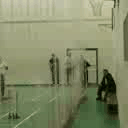

In [37]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
   
test_frames = predict_action(r"C:\Users\ADM\OneDrive\Desktop\data science\projects\dsa intern assessment\data\CricketBowling/v_CricketBowling_g02_c03.avi")
to_gif(test_frames[:MAX_SEQ_LENGTH])